# Diffusion 扩散模型 之 Score Matching



本笔记系列将介绍一种新的生成模型，diffusion 扩散概率模型 [ [ [ 1 ] ](#ref1)。diffusion 模型灵感来自热力学[ [ [ 2 ] ](#ref2)，同时也借鉴了denoising score matching[ [ [ 3 ] ](#ref3)，Langevin dynamics 和 autoregressive decoding等内容。

我们将探讨一系列最新 diffusion 的模型以及相关酷炫的应用，来帮助大家更好的理解这一领域的发展，本笔记系列包括如下内容：

   1. Score matching
   2. Langevin dynamics
   3. NCSN: Noise conditional score networks
   4. DDPM: Denoising Diffusion Probabilistic Models
   5. DDPM+: Improved Denoising Diffusion Probabilistic Models
   6. DDIM: DENOISING DIFFUSION IMPLICIT MODELS
   7. guided-diffusion: Diffusion Models Beat GANs on Image Synthesis 
 

这是本系列第一部分，在这个章节里，我们从最基础的 **score matching** 入手，这将帮助我们深刻理解 diffusion 模型。

本部分更加详细的解释参见博客：

本部分笔记来源：

## 1 Score matching

使用数据集为 swiss roll_ dataset。

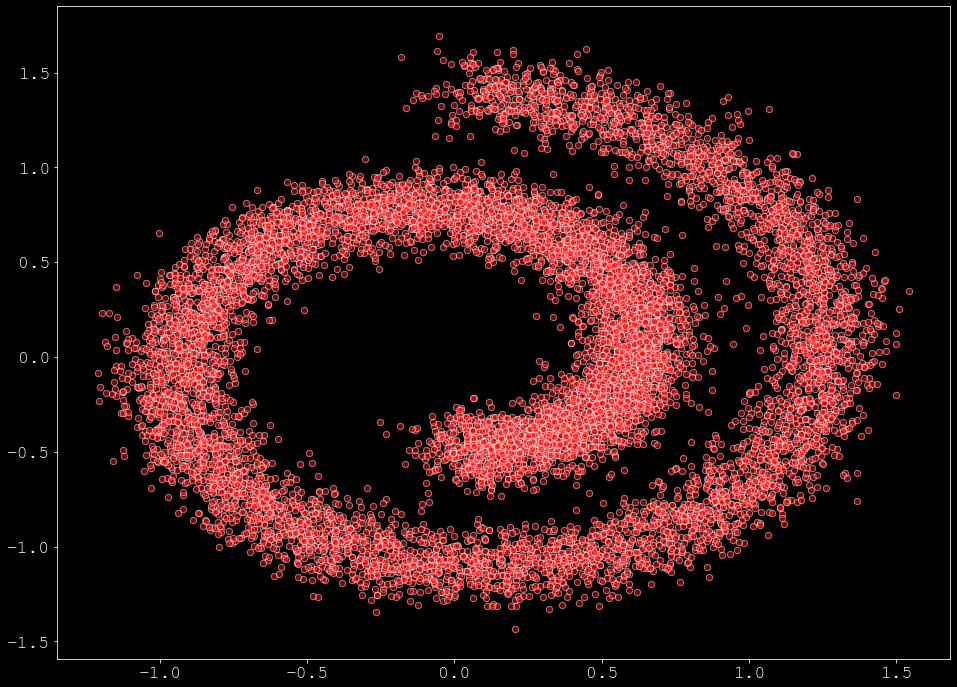

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import make_swiss_roll
from helper_plot import hdr_plot_style

hdr_plot_style()

# Sample a batch from the swiss roll
def sample_batch(size, noise=1.0):
    x, _= make_swiss_roll(size, noise=noise)
    return x[:, [0, 2]] / 10.0

# Plot it
data = sample_batch(10**4).T
plt.figure(figsize=(16, 12))
plt.scatter(*data, alpha=0.5, color='red', edgecolor='white', s=40)

**Score Matching** 的想法来源于 Hyvarinen et al. [ [ 6 ] ](#ref6)。不同于直接学习数据分布 $\log p(\mathbf{x})$, 我们的目标是学习 $\log p(\mathbf{x})$ 关于 $x$ 的梯度。

在此情况下,$\nabla_{\mathbf{x}} \log p(\mathbf{x})$ 是概率密度 $p(\mathbf{x})$ 的分数(score), 所以称之为 **score matching**。这可以被理解为学习输入空间中每个点的最大概率的方向，当模型训练好之后，我们可以将样本向最大概率的方向移动，以此来改进样本。

为了训练, 我们需要最小化 $\mathcal{F}_{\theta}(\mathbf{x})$ 与 $\nabla_{\mathbf{x}} \log p(\mathbf{x})$ 的误差, 损失函数可以是 **Fisher divergence** 或者简单的 **MSE**：

$$ \mathcal{L}_{mse} = E_{\mathbf{x} \sim p(\mathbf{x})} \left[ \left\lVert \mathcal{F}_{\theta}(\mathbf{x}) - \nabla_{\mathbf{x}} \log p(\mathbf{x}) \right\lVert_2^2 \right] $$

真实的 $\nabla_{\mathbf{x}} \log p(\mathbf{x})$ 通常是未知的, 对 $p(\mathbf{x})$ 做一些假设, 最小化 $\mathcal{L}_{mse}$ 等同于最小化如下目标函数：

$$ \mathcal{L}_{matching} = E_{\mathbf{x} \sim p(\mathbf{x})} \left[ \text{ tr}\left( \nabla_{\mathbf{x}}  \mathcal{F}_{\theta}(\mathbf{x})  \right) + \frac{1}{2} \left\Vert \mathcal{F}_{\theta}(\mathbf{x}) \right\lVert_2^2 \right]
, $$

式中 $\nabla_{\mathbf{x}} \mathcal{F}_{\theta}(\mathbf{x})$ 表示 $\mathcal{F}_{\theta}(\mathbf{x})$ 关于 $\mathbf{x}$ 的 Jacobian,  $ \text{tr}(\cdot) $ 是 _trace_ 运算。

为了进行优化, 我们可以使用 `Pytorch` 搭建 $\mathcal{F}_{\theta}(\mathbf{x})$ 的神经网络。

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
# Our approximation model
model = nn.Sequential(
    nn.Linear(2, 128), nn.Softplus(),
    nn.Linear(128, 128), nn.Softplus(),
    nn.Linear(128, 2)
)
# Create ADAM optimizer over our model
optimizer = optim.Adam(model.parameters(), lr=1e-3)

接下来, 我们需要定义 _score matching_ 目标的损失函数。

首先计算 Jacobian, 我们需要定义一个特别的 (可微分) 函数，这个高效的执行方式是基于这个讨论 [here](https://gist.github.com/sbarratt/37356c46ad1350d4c30aefbd488a4faa)

In [7]:
import torch.autograd as autograd

def jacobian(f, x):
    """Computes the Jacobian of f w.r.t x.
    :param f: function R^N -> R^N
    :param x: torch.tensor of shape [B, N]
    :return: Jacobian matrix (torch.tensor) of shape [B, N, N]
    """
    B, N = x.shape
    y = f(x)
    jacobian = list()
    for i in range(N):
        v = torch.zeros_like(y)
        v[:, i] = 1.
        dy_i_dx = autograd.grad(y, x, grad_outputs=v, retain_graph=True, create_graph=True, allow_unused=True)[0]  # shape [B, N]
        jacobian.append(dy_i_dx)
    jacobian = torch.stack(jacobian, dim=2).requires_grad_()
    return jacobian

_score matching_ 损失函数的计算分为：  首先计算 $\frac{1}{2} \left\Vert \mathcal{F}_{\theta}(\mathbf{x}) \right\lVert_2^2$，然后计算 $\text{ tr}\left( \nabla_{\mathbf{x}}  \mathcal{F}_{\theta}(\mathbf{x}) \right)$ ， 最后返回两者之和。

In [8]:
def score_matching(model, samples, train=False):
    samples.requires_grad_(True)
    logp = model(samples)
    # Compute the norm loss
    norm_loss = torch.norm(logp, dim=-1) ** 2 / 2.
    # Compute the Jacobian loss
    jacob_mat = jacobian(model, samples)
    tr_jacobian_loss = torch.diagonal(jacob_mat, dim1=-2, dim2=-1).sum(-1)
    return (tr_jacobian_loss + norm_loss).mean(-1)

运行代码训练模型：

In [9]:
dataset = torch.tensor(data.T).float()
for t in range(2000):
    # Compute the loss.
    loss = score_matching(model, dataset)
    # Before the backward pass, zero all of the network gradients
    optimizer.zero_grad()
    # Backward pass: compute gradient of the loss with respect to parameters
    loss.backward()
    # Calling the step function to update the parameters
    optimizer.step()
    if ((t % 500) == 0):
        print(loss)

tensor(-0.0388, grad_fn=<MeanBackward1>)
tensor(-19.0463, grad_fn=<MeanBackward1>)
tensor(-42.7619, grad_fn=<MeanBackward1>)
tensor(-49.5301, grad_fn=<MeanBackward1>)


绘制输入空间中的输出，可以看出模型能学到 $\mathcal{F}_{\theta}(\mathbf{x}) \approx \nabla_x \log p(x)$ 。

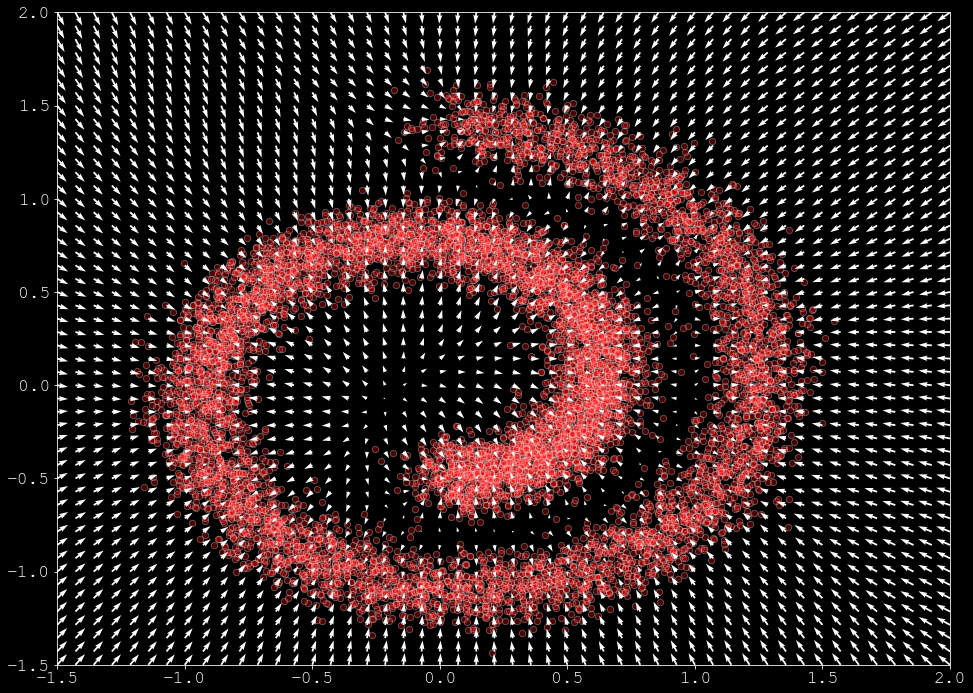

In [10]:
def plot_gradients(model, data, plot_scatter=True):
    xx = np.stack(np.meshgrid(np.linspace(-1.5, 2.0, 50), np.linspace(-1.5, 2.0, 50)), axis=-1).reshape(-1, 2)
    scores = model(torch.tensor(xx).float()).detach()
    scores_norm = np.linalg.norm(scores, axis=-1, ord=2, keepdims=True)
    scores_log1p = scores / (scores_norm + 1e-9) * np.log1p(scores_norm)
    # Perform the plots
    plt.figure(figsize=(16,12))
    if (plot_scatter):
        plt.scatter(*data, alpha=0.3, color='red', edgecolor='white', s=40)
    plt.quiver(*xx.T, *scores_log1p.T, width=0.002, color='white')
    plt.xlim(-1.5, 2.0)
    plt.ylim(-1.5, 2.0)
plot_gradients(model, data)

## 2 Langevin dynamics

训练完成之后, 模型就可以获得概率梯度的预测值，即 $\mathcal{F}_{\theta}(\mathbf{x}) \approx \nabla_x \log p(x)$。
借此我们可以通过梯度上升方法从一个初始样本 $\mathbf{x}_{0} \sim \mathcal{N}(\mathbf{0},\mathbf{I})$ 生成数据，然后使用梯度信息找到局部最大值
 $p(\mathbf{x})$：

$$\mathbf{x}_{t + 1} = \mathbf{x}_t + \epsilon \nabla_{\mathbf{x}_t} log p(\mathbf{x}_t)$$

式中 $\epsilon$ 表示梯度方向上的步长。

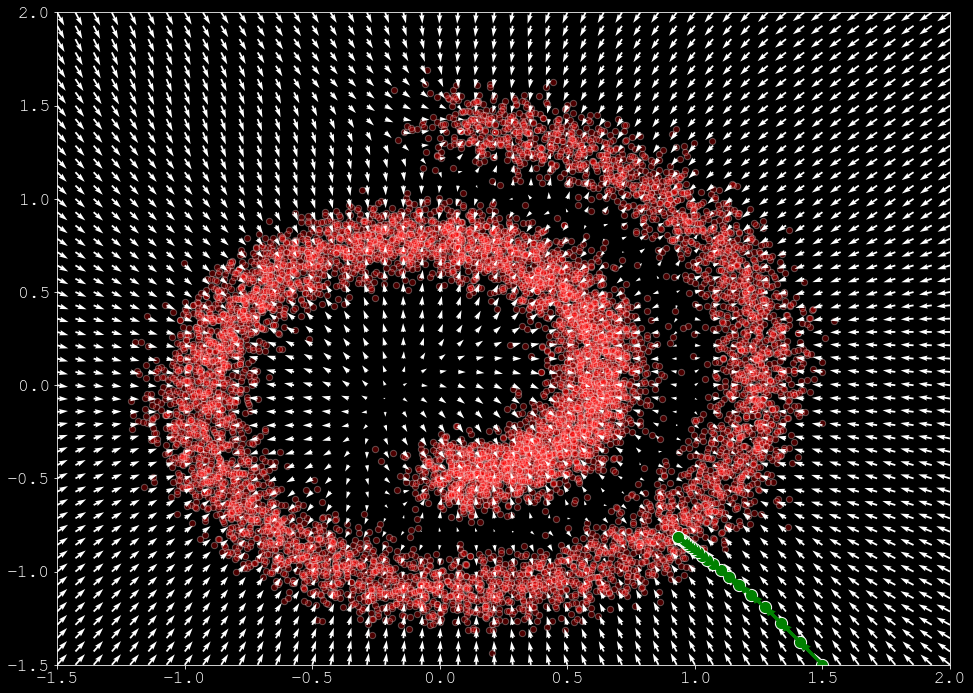

In [11]:
def sample_simple(model, x, n_steps=20, eps=1e-3):
    x_sequence = [x.unsqueeze(0)]
    for s in range(n_steps):
        x = x + eps * model(x)
        x_sequence.append(x.unsqueeze(0))
    return torch.cat(x_sequence)

x = torch.Tensor([1.5, -1.5])
samples = sample_simple(model, x).detach()
plot_gradients(model, data)
plt.scatter(samples[:, 0], samples[:, 1], color='green', edgecolor='white', s=150)
# draw arrows for each  step
deltas = (samples[1:] - samples[:-1])
deltas = deltas - deltas / np.linalg.norm(deltas, keepdims=True, axis=-1) * 0.04
for i, arrow in enumerate(deltas):
    plt.arrow(samples[i,0], samples[i,1], arrow[0], arrow[1], width=1e-4, head_width=2e-2, color="green", linewidth=3)

然而, 前面的过程并没有产生真实的样本 $\mathbf{x} \sim p(\mathbf{x})$。为了获得此样本，我们可以使用Langevin dynamics，它可以基于$\nabla_{\mathbf{x}} \log p(\mathbf{x})$ 产生来自概率密度 $p(\mathbf{x})$ 的真实样本, 采样的方式类似于 MCMC 方法, 递归式地生成：

$$\mathbf{x}_{t + 1} = \mathbf{x}_t + \frac{\epsilon}{2} \nabla_{\mathbf{x}_t} log p(\mathbf{x}_t) + \sqrt{\epsilon} \mathbf{z}_{t}$$

式中 $\mathbf{z}_{t}\sim \mathcal{N}(\mathbf{0},\mathbf{I})$

根据 [Welling et al. (2011)](https://www.ics.uci.edu/~welling/publications/papers/stoclangevin_v6.pdf) ，当 $\epsilon \rightarrow 0, t \rightarrow \inf$: $\mathbf{x}_t$ 将会收敛到真实的样本 $p(\mathbf{x})$， 这是 _score-based generative modeling_ 方法的关键思想。

为了执行上述采样过程, 我们可以再次从 $\mathbf{x}_{0} \sim \mathcal{N}(\mathbf{0},\mathbf{I})$ 出发, 然后再每一步逐步降低 $\epsilon \rightarrow 0$ ,最后将得到 $p(\mathbf{x})$。

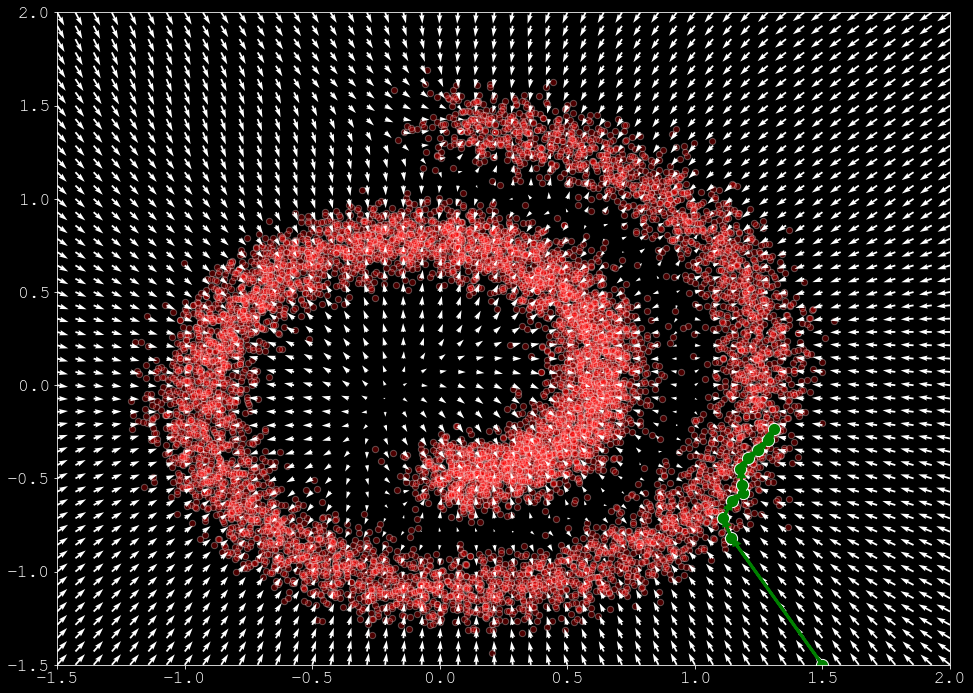

In [12]:
def sample_langevin(model, x, n_steps=10, eps=1e-2, decay=.9, temperature=1.0):
    x_sequence = [x.unsqueeze(0)]
    for s in range(n_steps):
        z_t = torch.rand(x.size())
        x = x + (eps / 2) * model(x) + (np.sqrt(eps) * temperature * z_t)
        x_sequence.append(x.unsqueeze(0))
        eps *= decay
    return torch.cat(x_sequence)

x = torch.Tensor([1.5, -1.5])
samples = sample_langevin(model, x).detach()
plot_gradients(model, data)
plt.scatter(samples[:, 0], samples[:, 1], color='green', edgecolor='white', s=150)
# draw arrows for each mcmc step
deltas = (samples[1:] - samples[:-1])
deltas = deltas - deltas / np.linalg.norm(deltas, keepdims=True, axis=-1) * 0.04
for i, arrow in enumerate(deltas):
    plt.arrow(samples[i,0], samples[i,1], arrow[0], arrow[1], width=1e-4, head_width=2e-2, color="green", linewidth=3)

## 3 Sliced score matching

前面定义的 _score matching_ 方法不适用于高维数据, 或者深度网络。

因为 $\text{ tr}\left( \nabla_{\mathbf{x}}  \mathcal{F}_{\theta}(\mathbf{x})  \right)$ 的计算量十分大， Jacobian计算量为 $O(N^2 + N)$ , 即使使用前面的优化代码，也无法计算高维数据。 

最近, Song et al. [ [ 7 ] ](#ref7) 提出随机投影的方法来近似计算 score matching 中的 $\text{ tr}\left( \nabla_{\mathbf{x}}  \mathcal{F}_{\theta}(\mathbf{x})  \right)$ 。 这个方法称为 _Sliced Score Matching_ ，此时优化目标变成：

$$ E_{\mathbf{v} \sim \mathcal{N}(0, 1)} E_{\mathbf{x} \sim p(\mathbf{x})} \left[ \mathbf{v}^T \nabla_{\mathbf{x}}  \mathcal{F}_{\theta}(\mathbf{x}) \mathbf{v} + \frac{1}{2} \left\Vert \mathbf{v}^T \mathcal{F}_{\theta}(\mathbf{x}) \right\lVert_2^2 \right]
, $$

式中 $\mathbf{v} \sim \mathcal{N}(0, 1)$ 是正太分布向量。可以使用前向过程 auto-differentiation 来高效计算。

In [13]:
def sliced_score_matching(model, samples):
    samples.requires_grad_(True)
    # Construct random vectors
    vectors = torch.randn_like(samples)
    vectors = vectors / torch.norm(vectors, dim=-1, keepdim=True)
    # Compute the optimized vector-product jacobian
    logp, jvp = autograd.functional.jvp(model, samples, vectors, create_graph=True)
    # Compute the norm loss
    norm_loss = (logp * vectors) ** 2 / 2.
    # Compute the Jacobian loss
    v_jvp = jvp * vectors
    jacob_loss = v_jvp
    loss = jacob_loss + norm_loss
    return loss.mean(-1).mean(-1)

损失函数的优化示例如下：

In [14]:
# Our approximation model
model = nn.Sequential(
    nn.Linear(2, 128), nn.Softplus(),
    nn.Linear(128, 128), nn.Softplus(),
    nn.Linear(128, 2)
)
# Create ADAM optimizer over our model
optimizer = optim.Adam(model.parameters(), lr=1e-3)
dataset = torch.tensor(data.T)[:1000].float()
for t in range(2000):
    # Compute the loss.
    loss = sliced_score_matching(model, dataset)
    # Before the backward pass, zero all of the network gradients
    optimizer.zero_grad()
    # Backward pass: compute gradient of the loss with respect to parameters
    loss.backward()
    # Calling the step function to update the parameters
    optimizer.step()
    # Print loss
    if ((t % 500) == 0):
        print(loss)

tensor(0.0359, grad_fn=<MeanBackward1>)
tensor(-0.7544, grad_fn=<MeanBackward1>)
tensor(-5.5483, grad_fn=<MeanBackward1>)
tensor(-9.4079, grad_fn=<MeanBackward1>)


使用前面定义的可视化函数检查结果：

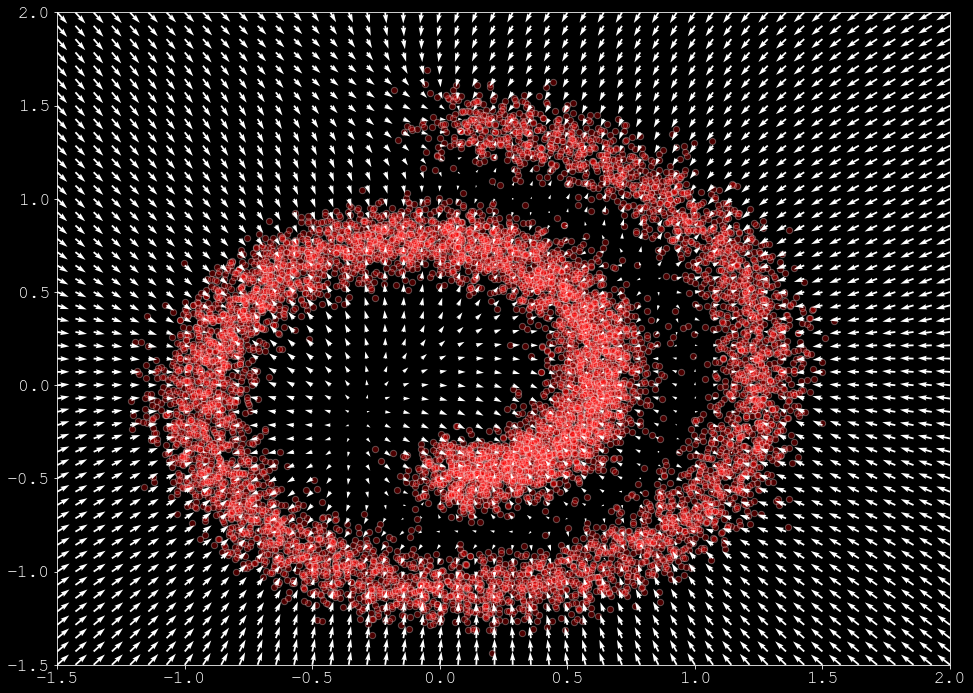

In [15]:
plot_gradients(model, data)

## 4 Denoising score matching

 _denoising score matching_ 最初由 Vincent [ [ 3 ] ](#ref3) 再 _denoising auto-encoders_ 提出，可以完全取消 $\nabla_{\mathbf{x}}  \mathcal{F}_{\theta}(\mathbf{x})$ 在 score matching 中的计算。 
 
 首先需要使用给定的噪声向量污染数据 $\mathbf{x}$ , 得到分布 $q_{\sigma}(\tilde{\mathbf{x}}\mid\mathbf{x})$。 然后用 score matching 来预测 **扰动之后数据分布的 score**。 
 
 最优网络 $\mathcal{F}_{\theta}(\mathbf{x}) \approx \nabla_{\mathbf{x}} \log p(\mathbf{x})$ 可以通过最小化如下目标获得：

$$ E_{q_{\sigma}(\tilde{\mathbf{x}}\mid\mathbf{x})} E_{\mathbf{x} \sim p(\mathbf{x})} \left[ \left\Vert \mathcal{F}_{\theta}(\tilde{\mathbf{x}}) - \nabla_{\tilde{\mathbf{x}}} \log q_{\sigma}(\tilde{\mathbf{x}}\mid\mathbf{x}) \right\lVert_2^2 \right]
, $$

值得注意的是当噪声足够小$q_{\sigma}(\mathbf{x}) \approx p(\mathbf{x})$ ，此时 $\mathcal{F}_{\theta}(\mathbf{x}) = \nabla_{\mathbf{x}} \log q_{\sigma}(\mathbf{x}) \approx \nabla_{\mathbf{x}} \log p(\mathbf{x})$ 才成立。

如果我们选择噪声分布为 $q_{\sigma}(\tilde{\mathbf{x}}\mid\mathbf{x})=\mathcal{N}(\tilde{\mathbf{x}}\mid\mathbf{x}, \sigma^{2}\mathbf{I})$, 则有 $\nabla_{\tilde{\mathbf{x}}} \log q_{\sigma}(\tilde{\mathbf{x}}\mid\mathbf{x}) = -\frac{\tilde{\mathbf{x}} - \mathbf{x}}{\sigma^{2}}$。

因此 denoising score matching 的损失函数可以简化为：

$$ \mathcal{l}(\theta;\sigma) = E_{q_{\sigma}(\tilde{\mathbf{x}}\mid\mathbf{x})} E_{\mathbf{x} \sim p(\mathbf{x})} \left[ \left\Vert \mathcal{F}_{\theta}(\tilde{\mathbf{x}}) +  \frac{\tilde{\mathbf{x}} - \mathbf{x}}{\sigma^{2}} \right\lVert_2^2 \right]
, $$

 _denoising score matching_ 的损失函数计算如下：

In [16]:
def denoising_score_matching(scorenet, samples, sigma=0.01):
    perturbed_samples = samples + torch.randn_like(samples) * sigma
    target = - 1 / (sigma ** 2) * (perturbed_samples - samples)
    scores = scorenet(perturbed_samples)
    target = target.view(target.shape[0], -1)
    scores = scores.view(scores.shape[0], -1)
    loss = 1 / 2. * ((scores - target) ** 2).sum(dim=-1).mean(dim=0)
    return loss

使用同样的模型和优化器：

In [17]:
# Our approximation model
model = nn.Sequential(
    nn.Linear(2, 128), nn.Softplus(),
    nn.Linear(128, 128), nn.Softplus(),
    nn.Linear(128, 2)
)
# Create ADAM optimizer over our model
optimizer = optim.Adam(model.parameters(), lr=1e-3)
dataset = torch.tensor(data.T).float()
for t in range(5000):
    # Compute the loss.
    loss = denoising_score_matching(model, dataset)
    # Before the backward pass, zero all of the network gradients
    optimizer.zero_grad()
    # Backward pass: compute gradient of the loss with respect to parameters
    loss.backward()
    # Calling the step function to update the parameters
    optimizer.step()
    # Print loss
    if ((t % 1000) == 0):
        print(loss)

tensor(10038.9043, grad_fn=<MulBackward0>)
tensor(10094.2500, grad_fn=<MulBackward0>)
tensor(9993.1592, grad_fn=<MulBackward0>)
tensor(10031.3828, grad_fn=<MulBackward0>)
tensor(9829.4570, grad_fn=<MulBackward0>)


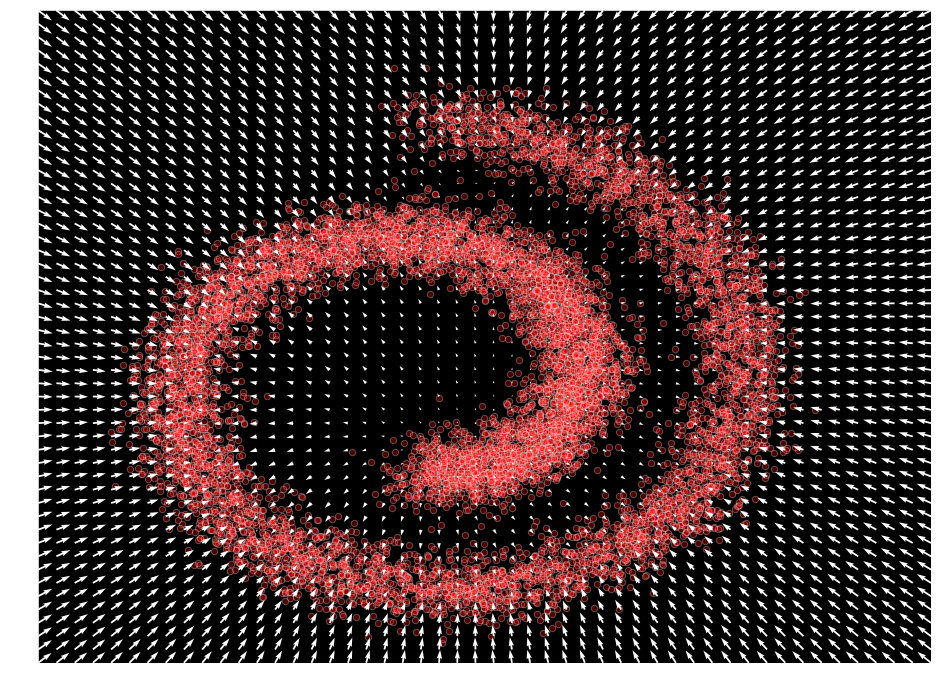

In [14]:
plot_gradients(model, data)

## 5 Noise conditional score networks

在最近的一篇论文中, Song and Ermon [ [ 8 ] ](#ref8) 基于这些想法提出了 score-based 生成网络框架，称为 _Noise-Conditional Score Networks_ (NCSN). 他们指出现在的 score matching 目标有如下缺陷：

- 使用没有 Noise 的 (sliced) score matching 与数据遵循流形的假设是不一致的，只有当数据分布填充满整个空间时才是一致的。

- 低密度区域可能会导致 score matching 和 Langevin dynamics 采样的困难。

为解决上述问题，他们提出扰动数据来避开 manifold 问题，同时通过训练一个conditional score network 来估计出所有噪声level的score，具体做法为：


考虑一个正的噪声方差序列 $\{\sigma_{i}\}_{i=1}^{L}$, 选择足够大的 $\sigma_{1}$ 来缓解 manifold 问题, 并且满足 $\frac{\sigma_{1}}{\sigma_{2}} = \cdots = \frac{\sigma_{L-1}}{\sigma_{L}} > 1$。 目标是训练一个 conditional network 来预测所有扰动数据分布的梯度：
$$
\forall \sigma \in \{\sigma_{i}\}_{i=1}^{L}, \mathcal{F}_{\theta}(\tilde{\mathbf{x}}, \sigma) \approx \nabla_{\mathbf{x}} \log q_{\sigma}(\mathbf{x})
$$

这个网络称为 _Noise Conditional Score Network_ (NCSN)。 为了优化, 使用之前定义的 denoising score matching 目标：
$$ \mathcal{l}(\theta;\sigma) = E_{q_{\sigma}(\tilde{\mathbf{x}}\mid\mathbf{x})} E_{\mathbf{x} \sim p(\mathbf{x})} \left[ \left\Vert \mathcal{F}_{\theta}(\tilde{\mathbf{x}}, \sigma) +  \frac{\tilde{\mathbf{x}} - \mathbf{x}}{\sigma^{2}} \right\lVert_2^2 \right]
, $$
这只是对应一种噪声 level，可以组合成一个统一的目标：
$$
\mathcal{L}(\theta;\{\sigma_{i}\}_{i=1}^{L}) = \frac{1}{L} \sum_{i=1}^{L} \lambda(\sigma_{i})\mathcal{l}(\theta;\sigma_{i})
$$
式中 $\lambda(\sigma_{i}) > 0$ 是依赖 $\sigma_{i}$ 的系数函数，具体实施如下：

In [15]:
def anneal_dsm_score_estimation(model, samples, labels, sigmas, anneal_power=2.):
    used_sigmas = sigmas[labels].view(samples.shape[0], *([1] * len(samples.shape[1:])))
    perturbed_samples = samples + torch.randn_like(samples) * used_sigmas
    target = - 1 / (used_sigmas ** 2) * (perturbed_samples - samples)
    scores = model(perturbed_samples, labels)
    target = target.view(target.shape[0], -1)
    scores = scores.view(scores.shape[0], -1)
    loss = 1 / 2. * ((scores - target) ** 2).sum(dim=-1) * used_sigmas.squeeze() ** anneal_power
    return loss.mean(dim=0)

模型需要一个 _conditional_ network $\mathcal{F}_{\theta}(\tilde{\mathbf{x}}, \sigma_{i})$ 将不同的噪声 level $\sigma_{i}$ 也作为输入：

In [16]:
import torch.nn.functional as F

class ConditionalLinear(nn.Module):
    def __init__(self, num_in, num_out, num_classes):
        super().__init__()
        self.num_out = num_out
        self.lin = nn.Linear(num_in, num_out)
        self.embed = nn.Embedding(num_classes, num_out)
        self.embed.weight.data.uniform_()

    def forward(self, x, y):
        out = self.lin(x)
        gamma = self.embed(y)
        out = gamma.view(-1, self.num_out) * out
        return out
    
class ConditionalModel(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.lin1 = ConditionalLinear(2, 128, num_classes)
        self.lin2 = ConditionalLinear(128, 128, num_classes)
        self.lin3 = nn.Linear(128, 2)
    
    def forward(self, x, y):
        x = F.softplus(self.lin1(x, y))
        x = F.softplus(self.lin2(x, y))
        return self.lin3(x)

模型训练如下：

In [17]:
sigma_begin = 1
sigma_end = 0.01
num_classes = 4
sigmas = torch.tensor(np.exp(np.linspace(np.log(sigma_begin), np.log(sigma_end), num_classes))).float()
# Our approximation model
model = ConditionalModel(num_classes)
dataset = torch.tensor(data.T).float()
# Create ADAM optimizer over our model
optimizer = optim.Adam(model.parameters(), lr=1e-3)
for t in range(5000):
    # Compute the loss.
    labels = torch.randint(0, len(sigmas), (dataset.shape[0],))
    loss = anneal_dsm_score_estimation(model, dataset, labels, sigmas)
    # Before the backward pass, zero all of the network gradients
    optimizer.zero_grad()
    # Backward pass: compute gradient of the loss with respect to parameters
    loss.backward()
    # Calling the step function to update the parameters
    optimizer.step()
    # Print loss
    if ((t % 1000) == 0):
        print(loss)

tensor(1.0319, grad_fn=<MeanBackward1>)
tensor(0.7983, grad_fn=<MeanBackward1>)
tensor(0.7847, grad_fn=<MeanBackward1>)
tensor(0.7673, grad_fn=<MeanBackward1>)
tensor(0.7460, grad_fn=<MeanBackward1>)


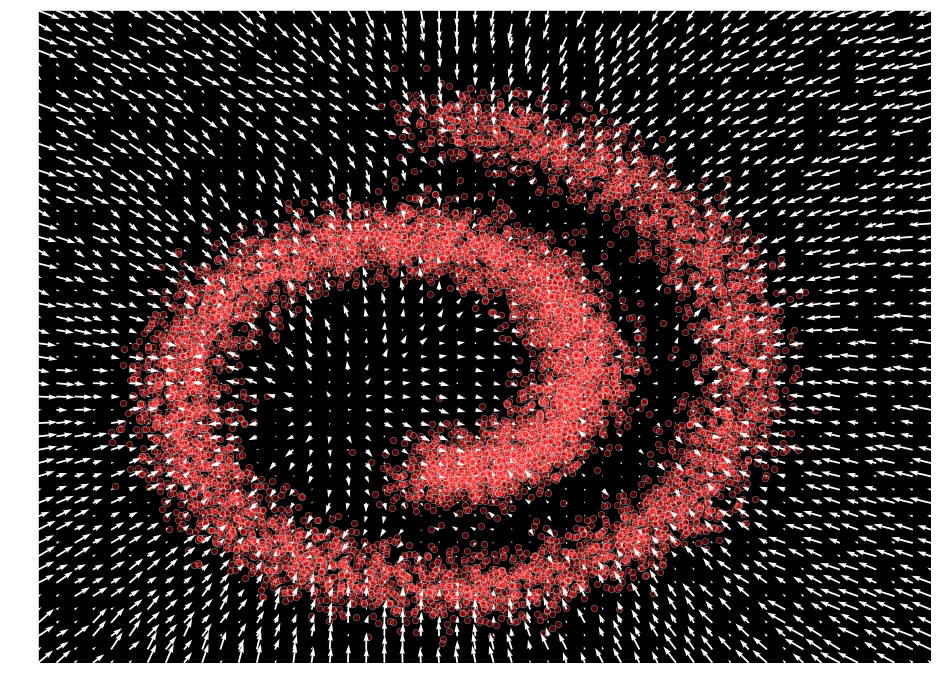

In [47]:
xx = np.stack(np.meshgrid(np.linspace(-1.5, 2.0, 50), np.linspace(-1.5, 2.0, 50)), axis=-1).reshape(-1, 2)
labels = torch.randint(0, len(sigmas), (xx.shape[0],))
scores = model(torch.tensor(xx).float(), labels).detach()
scores_norm = np.linalg.norm(scores, axis=-1, ord=2, keepdims=True)
scores_log1p = scores / (scores_norm + 1e-9) * np.log1p(scores_norm)
# Perform the plots
plt.figure(figsize=(16,12))
plt.scatter(*data, alpha=0.3, color='red', edgecolor='white', s=40)
plt.quiver(*xx.T, *scores_log1p.T, width=0.002, color='white')
plt.xlim(-1.5, 2.0)
plt.ylim(-1.5, 2.0);

(-1.5, 2.0)

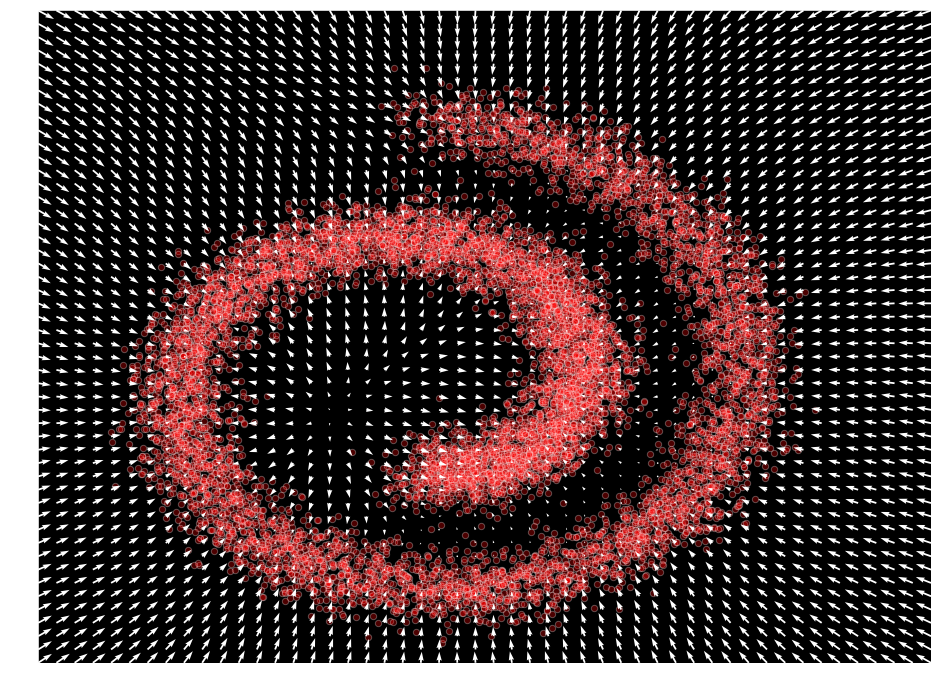

In [48]:
xx = np.stack(np.meshgrid(np.linspace(-1.5, 2.0, 50), np.linspace(-1.5, 2.0, 50)), axis=-1).reshape(-1, 2)
labels = torch.ones(xx.shape[0]).long()
scores = model(torch.tensor(xx).float(), labels).detach()
scores_norm = np.linalg.norm(scores, axis=-1, ord=2, keepdims=True)
scores_log1p = scores / (scores_norm + 1e-9) * np.log1p(scores_norm)
# Perform the plots
plt.figure(figsize=(16,12))
plt.scatter(*data, alpha=0.3, color='red', edgecolor='white', s=40)
plt.quiver(*xx.T, *scores_log1p.T, width=0.002, color='white')
plt.xlim(-1.5, 2.0)
plt.ylim(-1.5, 2.0)

## 参考

<a id="ref1"/>

[1] [Ho, J., Jain, A., & Abbeel, P. (2020). _Denoising diffusion probabilistic models_. arXiv preprint arXiv:2006.11239.](https://arxiv.org/pdf/2006.11239)

<a id="ref2"/>

[2] [Sohl-Dickstein, J., Weiss, E. A., Maheswaranathan, N., & Ganguli, S. (2015). Deep unsupervised learning using nonequilibrium thermodynamics. arXiv preprint arXiv:1503.03585.](https://arxiv.org/pdf/1503.03585)

<a id="ref3"/>

[3] [Vincent, P. (2011). A connection between score matching and denoising autoencoders. Neural computation, 23(7), 1661-1674.](http://www-labs.iro.umontreal.ca/~vincentp/Publications/smdae_techreport_1358.pdf)

<a id="ref4"/>

[4] [Song, J., Meng, C., & Ermon, S. (2020). Denoising Diffusion Implicit Models. arXiv preprint arXiv:2010.02502.](https://arxiv.org/pdf/2010.02502.pdf)

<a id="ref5"/>

[5] [Chen, N., Zhang, Y., Zen, H., Weiss, R. J., Norouzi, M., & Chan, W. (2020). _WaveGrad: Estimating gradients for waveform generation_. arXiv preprint arXiv:2009.00713.](https://arxiv.org/pdf/2009.00713)

<a id="ref6"/>

[6] [Hyvärinen, A. (2005). Estimation of non-normalized statistical models by score matching. Journal of Machine Learning Research, 6(Apr), 695-709.](http://jmlr.org/papers/volume6/hyvarinen05a/old.pdf)

<a id="ref7"/>

[7] [Song, Y., Garg, S., Shi, J., & Ermon, S. (2020, August). Sliced score matching: A scalable approach to density and score estimation. In Uncertainty in Artificial Intelligence (pp. 574-584). PMLR.](https://arxiv.org/pdf/1905.07088.pdf)

<a id="ref8"/>

[8] [Song, Y., & Ermon, S. (2019). Generative modeling by estimating gradients of the data distribution. In Advances in Neural Information Processing Systems (pp. 11918-11930).](https://arxiv.org/pdf/1907.05600.pdf)

## 其他资源

https://colab.research.google.com/github/google/jax/blob/master/docs/notebooks/score_matching.ipynb

https://github.com/ermongroup/sliced_score_matching